### Binary Classification Model for Kaggle Tabular Playground Series Mar 2021 Using Python and TensorFlow
### David Lowe
### June 4, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Mar 2021 dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset may be synthetic but is based on a real dataset and generated using a CTGAN. The original dataset tries to predict the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The performance of the cross-validated TensorFlow models achieved an average ROC benchmark of 0.8842 after running for 15 epochs. When we applied the final model to Kaggle's test dataset, the model achieved a ROC score of 0.8861.

CONCLUSION: In this iteration, the TensorFlow model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 Mar Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-mar-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-mar-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Jun  3 13:28:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.25

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = [tf.keras.metrics.AUC(name='roc_auc')]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 15
BATCH_SIZE = 32

# Define the labels to use for graphing the data
train_metric = "roc_auc"
validation_metric = "val_roc_auc"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.5.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [10]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [11]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id cat0 cat1 cat2 cat3  ...     cont7     cont8     cont9    cont10 target
0   0    A    I    A    B  ...  0.791921  0.815254  0.965006  0.665915      0
1   1    A    I    A    A  ...  0.408701  0.399353  0.927406  0.493729      0
2   2    A    K    A    A  ...  0.388835  0.412303  0.292696  0.549452      0
3   3    A    K    A    C  ...  0.897617  0.633669  0.760318  0.934242      0
4   4    A    I    G    B  ...  0.279167  0.351103  0.357084  0.328960      1

[5 rows x 32 columns]


In [12]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
 18  cat17   300000 non-null  object 
 19  cat18   300000 non-null  object 
 20  cont0   300000 non-null  float64
 21  cont1   30

In [13]:
print(df_dataset_import.describe())

                  id          cont0  ...         cont10         target
count  300000.000000  300000.000000  ...  300000.000000  300000.000000
mean   250183.425697       0.504749  ...       0.508230       0.264870
std    144320.334812       0.206788  ...       0.203393       0.441265
min         0.000000      -0.049562  ...       0.097789       0.000000
25%    125399.750000       0.344985  ...       0.368312       0.000000
50%    250192.500000       0.479650  ...       0.446576       0.000000
75%    375246.250000       0.637657  ...       0.581957       1.000000
max    499999.000000       1.004559  ...       1.011331       1.000000

[8 rows x 13 columns]


In [14]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [15]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

  cat0 cat1 cat2 cat3 cat4  ...     cont7     cont8     cont9    cont10 target
0    A    I    A    B    B  ...  0.791921  0.815254  0.965006  0.665915      0
1    A    I    A    A    E  ...  0.408701  0.399353  0.927406  0.493729      0
2    A    K    A    A    E  ...  0.388835  0.412303  0.292696  0.549452      0
3    A    K    A    C    E  ...  0.897617  0.633669  0.760318  0.934242      0
4    A    I    G    B    E  ...  0.279167  0.351103  0.357084  0.328960      1

[5 rows x 31 columns]


In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cat10   300000 non-null  object 
 11  cat11   300000 non-null  object 
 12  cat12   300000 non-null  object 
 13  cat13   300000 non-null  object 
 14  cat14   300000 non-null  object 
 15  cat15   300000 non-null  object 
 16  cat16   300000 non-null  object 
 17  cat17   300000 non-null  object 
 18  cat18   300000 non-null  object 
 19  cont0   300000 non-null  float64
 20  cont1   300000 non-null  float64
 21  cont2   30

In [17]:
print(df_dataset_import.describe())

               cont0          cont1  ...         cont10         target
count  300000.000000  300000.000000  ...  300000.000000  300000.000000
mean        0.504749       0.494073  ...       0.508230       0.264870
std         0.206788       0.213037  ...       0.203393       0.441265
min        -0.049562       0.084480  ...       0.097789       0.000000
25%         0.344985       0.317363  ...       0.368312       0.000000
50%         0.479650       0.463170  ...       0.446576       0.000000
75%         0.637657       0.693992  ...       0.581957       1.000000
max         1.004559       1.009958  ...       1.011331       1.000000

[8 rows x 12 columns]


In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = total_column_count

In [20]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_train = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_train = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_train = df_dataset_import.iloc[:,1:total_column_count]
    df_target_train = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 31) df_features_train.shape: (300000, 30) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

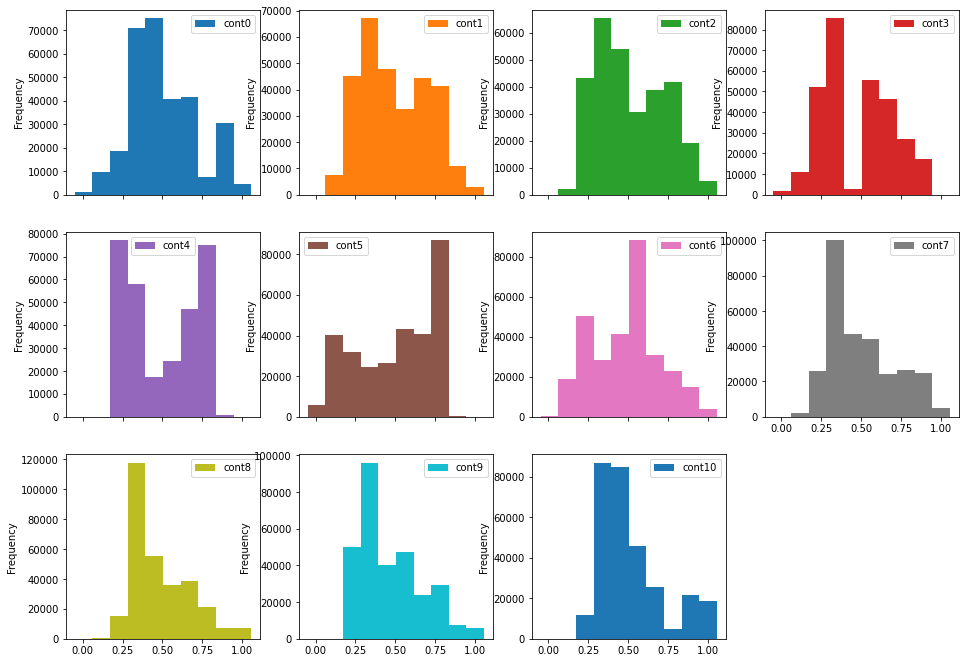

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

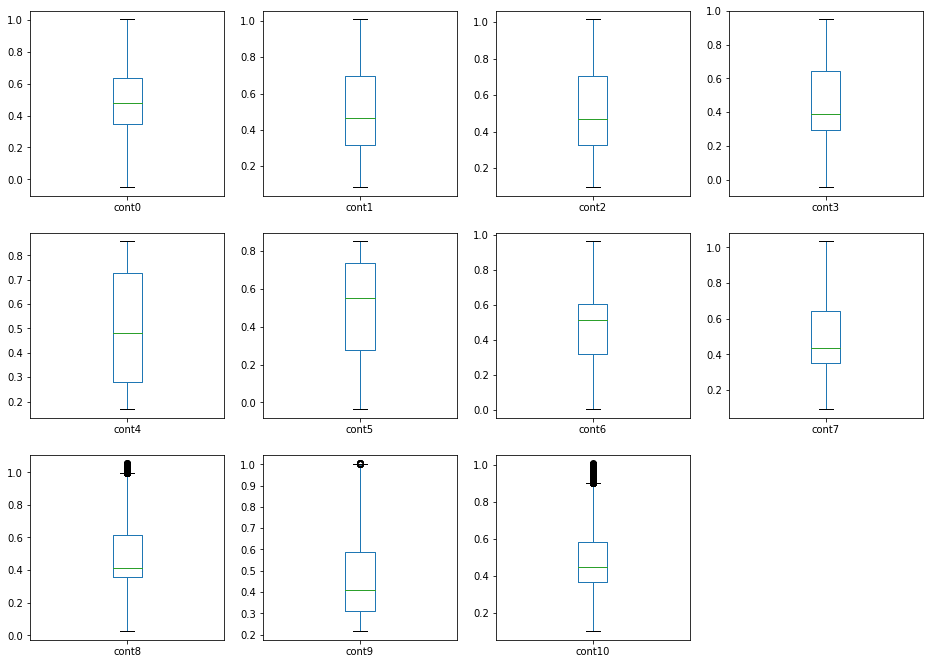

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

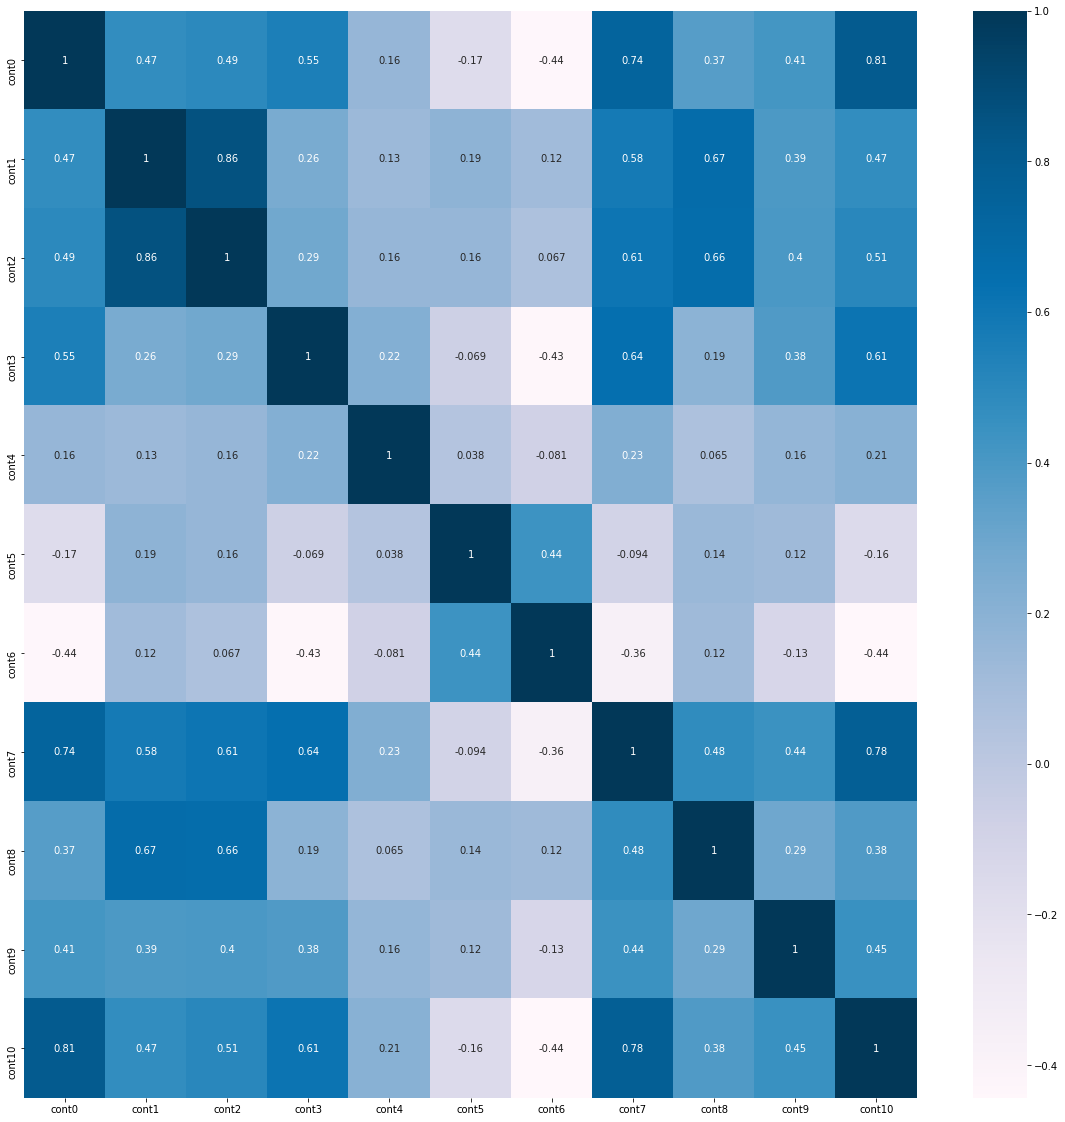

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [29]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [30]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=0))
#     ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool']).columns
categorical_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 11
Number of categorical columns: 19
Total number of columns in the feature dataframe: 30


In [31]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (300000, 30) to array_features_train.shape: (300000, 634)


### 3.c) Training Data Balancing

In [32]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [33]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [34]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (300000, 634) array_target_train.shape: (300000,)


In [35]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [36]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [37]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=array_features_train.shape[1], layer1_nodes=512, layer2_nodes=384, layer3_nodes=256, layer4_nodes=128, layer5_nodes=64,
                    layer1_dropout=0.25, layer2_dropout=0.25, layer3_dropout=0.25, layer4_dropout=0.25, layer5_dropout=0.25,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(layer3_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer3_dropout),
        keras.layers.Dense(layer4_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer4_dropout),
        keras.layers.Dense(layer5_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer5_dropout),
        keras.layers.Dense(1, activation=classifier_activation)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [38]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_roc_auc', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_features_train):
    feature_train, feature_validation = array_features_train[train_ix], array_features_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    reset_random()
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=1)[1]
    iteration = iteration + 1
    print('Score from iteration %d >>> %.4f' % (iteration, model_metric))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model scorer from all iterations: %.4f (%.4f)' % (validation_score, validation_variance))
print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

1875/1875 [==============================] - 4s 2ms/step - loss: 0.3772 - roc_auc: 0.8839
Score from iteration 1 >>> 0.8839
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3894 - roc_auc: 0.8868
Score from iteration 2 >>> 0.8868
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3691 - roc_auc: 0.8844
Score from iteration 3 >>> 0.8844
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3926 - roc_auc: 0.8801
Score from iteration 4 >>> 0.8801
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3715 - roc_auc: 0.8859
Score from iteration 5 >>> 0.8859
Average model scorer from all iterations: 0.8842 (0.0023)
Total time for model fitting and cross validating: 0:20:08.173171


In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [40]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [41]:
learning_rate_reduction = ReduceLROnPlateau(monitor='roc_auc', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
final_model = create_nn_model()
final_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[learning_rate_reduction], verbose=1)
final_model.summary()

Epoch 1/15
9375/9375 [==============================] - 25s 3ms/step - loss: 0.3717 - roc_auc: 0.8778
Epoch 2/15
9375/9375 [==============================] - 25s 3ms/step - loss: 0.3619 - roc_auc: 0.8834
Epoch 3/15
9375/9375 [==============================] - 24s 3ms/step - loss: 0.3581 - roc_auc: 0.8860
Epoch 4/15
9375/9375 [==============================] - 25s 3ms/step - loss: 0.3558 - roc_auc: 0.8877

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/15
9375/9375 [==============================] - 25s 3ms/step - loss: 0.3484 - roc_auc: 0.8922
Epoch 6/15
9375/9375 [==============================] - 25s 3ms/step - loss: 0.3458 - roc_auc: 0.8938
Epoch 7/15
9375/9375 [==============================] - 25s 3ms/step - loss: 0.3442 - roc_auc: 0.8948

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 8/15
9375/9375 [==============================] - 25s 3ms/step - loss: 0.3392 - roc_auc: 0.8981
Epoch 9/15
9375/9375 [

### 6.b) Load Test Dataset and Prepare the Submission File

In [42]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id cat0 cat1 cat2 cat3  ...     cont6     cont7     cont8     cont9    cont10
0   5    A    F    A    A  ...  0.551249  0.655693  0.598331  0.359987  0.947489
1   6    A    H    C    A  ...  0.248987  0.654614  0.347944  0.565520  0.388580
2   8    A    N    C    A  ...  0.746740  0.335590  0.341238  0.252289  0.411592
3   9    B    L    C    A  ...  0.538724  0.381566  0.481660  0.348514  0.325723
4  11    A    F    A    B  ...  0.178920  0.763479  0.562491  0.466261  0.585781

[5 rows x 31 columns]


In [43]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

   id
0   5
1   6
2   8
3   9
4  11


In [44]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

  cat0 cat1 cat2 cat3 cat4  ...     cont6     cont7     cont8     cont9    cont10
0    A    F    A    A    F  ...  0.551249  0.655693  0.598331  0.359987  0.947489
1    A    H    C    A    E  ...  0.248987  0.654614  0.347944  0.565520  0.388580
2    A    N    C    A    F  ...  0.746740  0.335590  0.341238  0.252289  0.411592
3    B    L    C    A    F  ...  0.538724  0.381566  0.481660  0.348514  0.325723
4    A    F    A    B    F  ...  0.178920  0.763479  0.562491  0.466261  0.585781

[5 rows x 30 columns]


In [45]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (200000, 30) to array_features_test.shape: (200000, 634)


In [46]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[[0.17061856]
 [0.4892134 ]
 [0.00547024]
 ...
 [0.6250627 ]
 [0.08132292]
 [0.5206092 ]]


In [47]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

   id    target
0   5  0.170619
1   6  0.489213
2   8  0.005470
3   9  0.162481
4  11  0.086389


In [48]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210603-1355.csv


In [49]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:26:56.119565
